# CAPSTONE PROJECT

---

### TITLE: 

USING MACHINE LEARNING TO TACKLE NEGATIVE SOCIAL MEDIA POSTS.

### ABSTRACT:

There is so much to love about social media, but we can agree social media bullying is on the rise. 

The purpose of this project is to tackle this problem by identifying what combination of words make up negative comments on social media platforms and creating a model that can predict if a user’s post is negative before it is posted online.

---


## 1) THE DATASET

The dataset used for this project was retrived from kaggle.com. It contains 31,962tweets from several Twitter users. 

For security reasons, the users' identity have been removed from this dataset i.e. Twitter user's `@name` is replaced with `@user`. 

Each tweet in the dataset have also been labelled as been 1-Negative or 0-Positive tweets.

***NOTE:***

    Negative tweets (class label = 1) are those found to be hateful and or offensive (sexist/political/racist). While Positive 
    tweets (class label = 0) are loving, kind or neutral.

Find the dataset here https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

---

***Some of the Python libraries that will be needed.***

In [2]:
#Exploration and visualization libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

pd.set_option('display.max_column', None)

#Natural Language processing(NLP) libraries
#nltk.download()
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#String processing libraries
import string
import re

#Imbalance learn library
import imblearn as imb

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

#### Reading in the dataset

In [3]:
data_df = pd.read_csv(r'C:\Users\gorot\Desktop\BrainStation_DS\Projects\Final_Project\Possible_Datasets\Twitter\train.csv')
data_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
#Number of rows and columns in the data
print('Shape of dataset:',data_df.shape)

Shape of dataset: (31962, 3)


In [5]:
#Size of class labels
data_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

#### Dataset Summary:

The dataset has;

31,962 data points with 3 features(id, label, tweet)

    Negative(1): 2,242(7.0%)
    
    Positive(0): 29,720(93%)

To avoid overwritting the actual data, a new dataset will be created with the neccesary features of the data needed for this project.

In [6]:
#Keep only the features needed in the new dataframe
main_df = data_df.loc[:,['label','tweet']]
main_df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
#Number of rows and columns in the new dataset
main_df.shape

(31962, 2)

In [8]:
#Distribution of the label (0,1)
main_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
#Visualizing the distribution of class label
bar1 = go.Bar(x =main_df['label'].value_counts().index, y=main_df['label'].value_counts().values)

layout = go.Layout(title = 'Size of class label',
                  xaxis = dict(title = 'Class Label'),
                  yaxis = dict(title = 'Class Size'), 
                   width = 400, height = 600)

fig = go.Figure(data = bar1, layout = layout)
fig.show()

The data appear to be imbalance as seen in the above plot. That is, the volume of Positive tweet (class label = 0) outweights the Negative tweets (class label = 1). This may have an impact on the model's accuray. A possible way to balance the data would be to consider oversampling the negative class, or undersampling the positive class in the dataset. This will be further addressed in a later step.

## 2) PREPROCESSING

### Train/Test Split

The dataset will be splitted into two sets; 

***80% of the data will be used for training the model. The remaining 20% will be set aside to test/evaluating the model's perfromance.***

To split the data, the Stratified Random Sampling(SRS) technique will be used. This will ensure that the distribution of the class labels is reflective in both samples. 

In [12]:
#Seperate test data from main data
from sklearn.model_selection import train_test_split

X_rem, X_test, y_rem, y_test = train_test_split(main_df['tweet'], main_df['label'], test_size = 0.2, shuffle = True, 
                                                stratify = main_df['label'], random_state = 1234)

In [13]:
#Shape of each dataset
print('Shape of X_rem:', X_rem.shape)
print('Shape of y_rem:', y_rem.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_rem: (25569,)
Shape of y_rem: (25569,)
Shape of X_test: (6393,)
Shape of y_test: (6393,)


In [23]:
#Combine X_rem and y_rem back into a DataFrame
rem_df = pd.merge(X_rem,y_rem, left_index = True, right_index = True).reset_index(drop = True)

In [24]:
#Checking that no data points were lost during trabsformation
rem_df.shape

(25569, 2)

### Natural Language Processing

Natural Language Processing(NLP) techniques will be applied to the text data as an initial pre-processing step using built-in functions from the python natural language tool kit (nltk) library.

Applying these python built-in functions cleans and transforms the text data into a more useful format.

The NLTK steps will include;

1) Tokenization

2) Puctuation removal

3) Stopword removal

4) Lemmatization

5) Stemming

6) Corpus(Bagofwords)


#### Building the NLP functions

In [15]:
#Function tokenizes each sentence t.e. splits sentence into individual words(tokens)

def tokenizer(text):
    '''
    Splits sentences into individual words(tokens)
    '''
    return word_tokenize(text)

In [16]:
#Remove punctuations
def punct_remover(text):
    
    '''
    Identifies and remove
    punctuations. 
    '''
    
    punct_list = string.punctuation
    
    punct_removed_text = []
    
    for token in text:
        
        if token in punct_list: continue
        punct_removed_text.append(token)
    
    return punct_removed_text       

In [17]:
#Define stop word removal function that removes functions from text and adds it to existing token list 

def stopword_remover(token_list):
    
    '''
    Remove stop words(english) from text. 
    
    For this project, 'user' will be added to the list of stop words.
    '''
    
    stop = stopwords.words('english') + ['user'] #add user to list of english stopwords
    
    stop_removed_text = []
    
    for token in token_list:
        if token in stop: continue
        stop_removed_text.append(token) 
        
    return stop_removed_text     

In [18]:
#Define function that performs lemmatization on texts i.e changes texts to its dictionary form
def word_lemmatizer(token_list):
    
    '''
    Keep texts in their dictionary form.
    '''
    
    lemma = WordNetLemmatizer()
    
    lemmatized_tokens = []
    
    for i in token_list:
        token = lemma.lemmatize(i)
        
        lemmatized_tokens.append(token)
        
    return lemmatized_tokens

In [19]:
#Define function that stems text by reducing token to its unchangeable format
def word_stemmer(token_list):
    
    '''
    Remove extended words and keep the base unchangeable form.
    '''
    
    stemmer = PorterStemmer()
    
    stemmed_token = []
    
    for i in token_list:
        
        token = stemmer.stem(i)
        
        stemmed_token.append(token)
        
    return stemmed_token   

In [20]:
#Function joins the cleaned text back into a string

def untokenizer(token):
    
    '''
    Concatenate token back to string
    '''
    untoken = ' '.join(token)
    
    return untoken

In [21]:
def Text_cleaner(data):
    
    '''
    Text_cleaner combines all the above defined functions.
    '''
    
    cleaned_tweet = []
    data_length = len(data)

    #FUNCTIONS OF THE TEXT CLEANER
    
    data = data.apply(lambda x: re.sub('[^A-Za-z\s]', ' ',x))
    
    for i in range(data_length):
        
        tweet = data[i]

        #split the sentence/phrase into tokens
        tokenized_text = tokenizer(tweet)

        #keep text in all lower case
        lc_text = [t.lower() for t in tokenized_text]

        #Remove punctuations
        no_punct_text = punct_remover(lc_text)

        #Remove english stop words 
        no_stopwords = stopword_remover(no_punct_text)

        #lemmatize text by changing it to its dictonary form
        lemm_text = word_lemmatizer(no_stopwords)

        #Remove stemmers by applying stemmation (remove s,ing,ly etc)
        stemed_text = word_stemmer(lemm_text)

        #untokenize text back into a string
        cleaned_text = untokenizer(stemed_text)

        #append cleaned texts back to the list
        cleaned_tweet.append(cleaned_text)

    return cleaned_tweet

In [31]:
#Apply the Text_cleaner function to the rem_df data
rem_df['cleaned_tweet'] = Text_cleaner(rem_df['tweet'])

In [33]:
#Sanity check: To make sure the Text_cleaner function worked
print('OLD TWEET:\n',rem_df['tweet'][8])

print('\nNEW CLEANED TWEET:\n',rem_df['cleaned_tweet'][8])

OLD TWEET:
  @user every single day without any doubt you make me smile ð @user #boyfriend   ððð«

NEW CLEANED TWEET:
 everi singl day without doubt make smile boyfriend


The above preview shows the difference between the raw text data and the cleaned text. The words in the texts have been transformed, special characters have also been removed.

In [36]:
#Drop/Delete old tweet column from DataFrame
rem_df.drop(columns = ['tweet'], inplace = True)
rem_df.head()

,label,cleaned_tweet
0,0,rip soul morelov lovepleas monday heabroken or...
1,0,father day
2,0,back see yr group tomorrow get sign term time ...
3,0,differ cav gsw ryt hea win
4,0,love eyebrow go fuck perfectli


### Missing Values

Removing missing and/or duplicated rows in the dataset.

In [37]:
#Check for missing values
rem_df.isna().any()

label            False
cleaned_tweet    False
dtype: bool

No missing values detected in the dataset.

### Duplicated values

In [38]:
#Check if any of the rows are duplicated
rem_df.duplicated(keep = 'first').value_counts()

False    22802
True      2767
dtype: int64

2,767 duplicated records are present in the rem_df dataset. These duplicates will be removed.

In [40]:
#Remove all duplicates
rem_cln = rem_df[rem_df.duplicated(keep = 'first') != True]

#Shape of data after all duplicates have been removed
rem_cln.shape

(22802, 2)

In [41]:
#Check if duplicates are still presesent in the data
rem_cln.duplicated().value_counts()

False    22802
dtype: int64

In [42]:
#Instantiate bar graph

bar1 = go.Bar(x =rem_cln['label'].value_counts().index, y=rem_cln['label'].value_counts().values)

layout = go.Layout(title = 'Data label volume',
                  xaxis = dict(title = 'Tweet label'),
                    yaxis = dict(title = 'Size'), width = 400,
            height = 600)

fig = go.Figure(data = bar1, layout = layout )

fig.show()

Them rem_cln dataset now have 22,802 records. Of which, 21,315(93.5%) are positive and 1,487(6.5%) are negative labelled tweets.

## Feature Engineering

In [43]:
#Seperating cleaned tweets into a different table
words = rem_cln['cleaned_tweet']

In [44]:
#Using the python sklearn built in function countvectorizer to transform the cleaned tweets into a corpus
from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bow = CountVectorizer(min_df = 3, ngram_range = (1,3))

#fit and transform
words_vec = bow.fit(words).transform(words)

In [45]:
words_vec

<22802x11870 sparse matrix of type '<class 'numpy.int64'>'
	with 180294 stored elements in Compressed Sparse Row format>

In [47]:
#Create new dataframe with created corpus
words_vec_df = pd.DataFrame(words_vec.todense(), columns = bow.get_feature_names())

#Shape of newly created dataframe
words_vec_df.shape

(22802, 11870)

In [48]:
#Defining X(data/independent) and y(target/dependent) features

X = words_vec_df
print('Shape of data(X):' ,X.shape)

y = rem_cln['label']
print('Shape of target(y):',y.shape)

Shape of data(X): (22802, 11870)
Shape of target(y): (22802,)


### Training/Validation Set

70% of the data will be used for training the model, the outstanding 30% will be used to validate the models accuracy.

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, stratify = y)

In [50]:
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_val:',X_val.shape)
print('y_val:',y_val.shape)

X_train: (15961, 11870)
y_train: (15961,)
X_val: (6841, 11870)
y_val: (6841,)


### Principal Component Analysis

Currently the data has over 11,000 features. 
Principal Component Analysis(PCA) will be fitted on the training set, then used to tranform the validation set. This will reduce the data's dimensionality by including only features explaining the data variance.

In [65]:
%%time
#Dimensionality reduction using PCA
from sklearn.decomposition import PCA

#instantiate PCA. Keep only components that explains 85% of the variance in the dataset
my_pca = PCA(n_components = 0.85)

#fit and transform
X_train_pca = my_pca.fit(X_train).transform(X_train)

#Transform X validation set
X_val_pca = my_pca.transform(X_val)

Wall time: 30min 43s
Parser   : 157 ms


In [66]:
my_pca.components_

array([[ 1.04869613e-05, -3.10960912e-06,  8.61540352e-06, ...,
        -9.43097473e-09,  9.89170021e-01,  1.46686350e-01]])

---

## 3) LEARNING ALGORITHM

## Model 1: Logistic Regression Model (PCA)

In [67]:
#Fit a simple logistic regression model
from sklearn.linear_model import LogisticRegression

#Hyperparameter optimization
lr_model_pca = LogisticRegression()

#fit
lr_model_pca.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluation

In [68]:
#Accuracy
print('Train Accuracy:',lr_model_pca.score(X_train_pca, y_train))

print('Validation Accuracy:', lr_model_pca.score(X_val_pca, y_val))

Train Accuracy: 0.9348370927318296
Validation Accuracy: 0.9347953216374268


In [69]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

#predict X_val
y_pred_pca = lr_model_pca.predict(X_val_pca)

print(classification_report(y_val, y_pred_pca))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      6394
           1       0.00      0.00      0.00       446

    accuracy                           0.93      6840
   macro avg       0.47      0.50      0.48      6840
weighted avg       0.87      0.93      0.90      6840



In [71]:
#Confusion Matrix
print('Confusion Matrix:\n', confusion_matrix(y_val,y_pred_pca))

Confusion Matrix:
 [[6394    0]
 [ 446    0]]


## Model 2: Logistic Regression Model (No PCA)

In [51]:
#Fit a simple logistic regression model
from sklearn.linear_model import LogisticRegression

#Hyperparameter optimization
lr_model_nopca = LogisticRegression()

#fit
lr_model_nopca.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluation

In [52]:
#Accuracy
print('Train Accuracy:',lr_model_nopca.score(X_train, y_train))

print('Validation Accuracy:', lr_model_nopca.score(X_val, y_val))

Train Accuracy: 0.9766931896497714
Validation Accuracy: 0.9545388101154801


In [53]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

#predict X_val
y_pred_nopca = lr_model_nopca.predict(X_val)

print(classification_report(y_val, y_pred_nopca))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6395
           1       0.79      0.41      0.54       446

    accuracy                           0.95      6841
   macro avg       0.88      0.70      0.76      6841
weighted avg       0.95      0.95      0.95      6841



In [54]:
#Confusion matrix
print(confusion_matrix(y_val, y_pred_nopca))

[[6346   49]
 [ 262  184]]


## Model 3: Xtreme Gradient Boosting (XGBoost)

In [292]:
#import package
from xgboost import XGBClassifier

In [294]:
%%time
#Instantiate model
xgb = XGBClassifier(n_estimators= 50)

#Fit to training data
xgb.fit(X_train, y_train)

#Evalute
print('Train Accuracy:', xgb.score(X_train, y_train))
print('Validate Accuracy:', xgb.score(X_val, y_val))

Train Accuracy: 0.9411654135338345
Validate Accuracy: 0.9409356725146198
Wall time: 24min 37s


In [295]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

#predict X_val
y_pred_xgb = xgb.predict(X_val)

print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6394
           1       0.86      0.11      0.20       446

    accuracy                           0.94      6840
   macro avg       0.90      0.56      0.58      6840
weighted avg       0.94      0.94      0.92      6840



The three models have a good accuracy over 90%. But comparing the classification reports, Model 2's negative class recall and f1 score is higher meaning it predicts the negative class better than Models 1 and 3. 

Imbalance in the data could be a reason why the models are not so good at predicting the negtive class. A possible attempt to getting better predictions of the negative class will be to oversample the data and re-fit the above models.

## Handling imbalanced dataset

### Oversampling Technique 

The negative tweets will be oversampled to adjust the imbalance in the dataset. The Naive Random Over-sampling Technique will be used in this case.

In [105]:
#A remainder on the X_train and y_train 
print('X-train:', X_train.shape)
print('y-train:', y_train.shape)

X-train: (15960, 11872)
y-train: (15960,)


In [185]:
#Oversampling train data with Random naive sampling of the imbalance learn package

from imblearn.over_sampling import RandomOverSampler

#instantiate
ros = RandomOverSampler(sampling_strategy= 1.0) #ratio 1:1

#Fit to training set
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [186]:
#shape of oversampled sets

print('Oversampled X train set:',X_train_os.shape)

print('Oversampled y train set:',y_train_os.shape)

Oversampled X train set: (29840, 11872)
Oversampled y train set: (29840,)


In [187]:
%%time
#Applying PCA to oversampled train set
from sklearn.decomposition import PCA

#instantiate 
my_pca2 = PCA(n_components = 0.85) #Keep features that explains 85% of the dataset variance

#Fit and transform
X_train_pca2 = my_pca2.fit(X_train_os).transform(X_train_os)

#Transform X_val
X_val_pca2 = my_pca2.transform(X_val)

Wall time: 1h 25min 27s


Below, two additional models are fitted on the oversampled data maybe this will improve the recall and f1 score of the negative class.

### Model 1: Logistic Regression

In [191]:
#Fit a simple logistic regression model to the oversampled data
from sklearn.linear_model import LogisticRegression

#Hyperparameter optimization
lr_model_os = LogisticRegression()

#fit
lr_model_os.fit(X_train_pca2, y_train_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
#Model accuracy
print('Train accuracy:', lr_model_os.score(X_train_pca2,y_train_os))
print('Validation accuracy:', lr_model_os.score(X_val_pca2, y_val))

Train accuracy: 0.537902144772118
Validation accuracy: 0.525


In [193]:
#Classification report

y_pred_os = lr_model_os.predict(X_val_pca2)

print(classification_report(y_val, y_pred_os))

              precision    recall  f1-score   support

           0       0.95      0.52      0.67      6394
           1       0.08      0.58      0.14       446

    accuracy                           0.53      6840
   macro avg       0.51      0.55      0.41      6840
weighted avg       0.89      0.53      0.64      6840



In [194]:
#Confusion matrix
print(confusion_matrix(y_val, y_pred_os))

[[3331 3063]
 [ 186  260]]


### Model 2: Random Forest Classifier

In [199]:
#fitting a Random Forest

from sklearn.ensemble import RandomForestClassifier

#instantiate
rfc = RandomForestClassifier(n_estimators=50) #Restrict Number of fitted DT classifiers to 50

#Fit
rfc.fit(X_train2, y_train_os)

#Evaluate Accuracy
print('Train acc:', rfc.score(X_train2, y_train_os))
print('Validation acc:', rfc.score(X_val2, y_val))


Train acc: 0.9984919571045576
Validation acc: 0.8818713450292398


In [201]:
y_pred_rfc = rfc.predict(X_val2)

#Classification Report
print('Classification Report\n\n',classification_report(y_val,y_pred_rfc))

#Confusion matrix
print('\nConfusion matrix\n\n',confusion_matrix(y_val,y_pred_rfc))

Classification Report

               precision    recall  f1-score   support

           0       0.94      0.94      0.94      6394
           1       0.10      0.10      0.10       446

    accuracy                           0.88      6840
   macro avg       0.52      0.52      0.52      6840
weighted avg       0.88      0.88      0.88      6840


Confusion matrix

 [[5987  407]
 [ 401   45]]


---
# Final Model

## Hyperparameter Optimization

Finding the best combination of parameters that optimizes the model's performance.

In [55]:
from sklearn.model_selection import cross_val_score

c_range = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 1.0, 10, 100, 1000, 10000, 100000]

scores = list()

for c in c_range:
    
    #Instantiate Logistic Regression model using Ridge penalty:
    lr_model2 = LogisticRegression(penalty = 'l2', C = c) 
    
    #K-fold cross validation. K = 5
    
    val_scores = cross_val_score(lr_model2,X_train,y_train, cv = 5)
    
    avg_score = np.mean(val_scores)
    
    scores.append(avg_score)


#Instantiate plot

trace_3 = go.Scatter(x = c_range, y = scores, name = 'Validation scores', mode = 'lines+markers' )

layout = go.Layout(title = 'Hyperparameter Optimization: Average validation scores',
                  xaxis = dict(title = 'c value', type = 'log'),
                  yaxis = dict(title = 'Val. score'))

fig = go.Figure(data = trace_3, layout = layout)

fig.show()

Hyper parameters optimized at C = 1 (alpha = 1/C = 1, regularization penalty = L2(Ridge)).

### Model of Best fit

In [56]:
#Fit a simple logistic regression model
from sklearn.linear_model import LogisticRegression

#Hyperparameter optimization
lr_model = LogisticRegression(penalty = 'l2', C = 1)

#fit
lr_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Final Model: Evaluation

In [57]:
#Accuracy
print('Train Accuracy:',lr_model.score(X_train, y_train))

print('Validation Accuracy:', lr_model.score(X_val, y_val))

Train Accuracy: 0.9766931896497714
Validation Accuracy: 0.9545388101154801


In [58]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

#predict X_val
y_pred = lr_model.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6395
           1       0.79      0.41      0.54       446

    accuracy                           0.95      6841
   macro avg       0.88      0.70      0.76      6841
weighted avg       0.95      0.95      0.95      6841



In [59]:
#Confusion matrix
print(confusion_matrix(y_val, y_pred))

[[6346   49]
 [ 262  184]]


In [60]:
#ROC and AUC

#predict probabilities for the negative class
y_proba = lr_model.predict_proba(X_val)[:,1] 

from sklearn.metrics import roc_curve,roc_auc_score

fprs, tprs, thresholds = roc_curve(y_val, y_proba, pos_label = 1)

roc_auc = roc_auc_score(y_val, y_proba)

#ROC Plot
trace_1 = go.Scatter(x=fprs, y = tprs,  name = 'AUC: %0.2f' %roc_auc)
trace_2 = go.Scatter(x=[0,1], y = [0,1], line = dict(dash = 'dash'), showlegend=False)

data = [trace_1,trace_2]

layout = go.Layout(title = 'ROC Curve',
                  xaxis = dict(title = 'False positive rate'),
                  yaxis = dict(title = 'True positive rate'))

fig = go.Figure(data = data, layout = layout)

fig.show()

The Receiver Operating Characteristics (ROC) curve shows  that the model is a good classifier. The graph shows that at 80% true positive rate, only 10% are false positives.

AUC (Area Under the Curve) of 0.93 also shows that the model is good at seperating the true positives from the false positives.

These measurements are quite effective considering the model was fitted on imbalanced data.

### Model Coefficient

Words identified by the model to be significant.

In [63]:
#Top 50 words
pd.Series(lr_model.coef_[0], index = X_train.columns).nlargest(50)

allahsoil         3.849275
racism            3.220667
white             2.680076
boycott           2.398861
bigot             2.340451
paladino          2.191395
notmypresid       2.167674
blacklivesmatt    2.074509
misogyni          1.967522
latest            1.918310
malevot           1.899023
misogynist        1.879189
nazi              1.776872
treason           1.770195
blm               1.749557
woman             1.742875
jew               1.719825
equal             1.690601
racist            1.689386
fascism           1.645035
race              1.592950
rohingya          1.591815
antisemit         1.547122
trump             1.534906
slaveri           1.533651
respond           1.530340
feminist          1.519588
bigotri           1.501208
effect            1.495585
aicl              1.489411
snowflak          1.485993
democraticpay     1.485596
obama             1.461229
povey             1.455957
scumbag           1.437806
arab              1.434215
blatantli         1.432198
s

Above is the list of the top 50 significant words identified by the model to be negative. These are words that carried the most weight. When they appear in a tweet, then the tweet is negative.

---

## 4) MODEL TESTING

Testing will be on the data (X_test, y_test) that was set aside in the very first step

In [92]:
#Add test data to a new dataframe
test_df = pd.DataFrame.merge(X_test, y_test, how = 'inner', right_index = True, left_index = True)

#Reset index
test_df = test_df.reset_index(drop = True)

#Apply the Text_cleaner function to the rem_df data
test_df['cleaned_tweet'] = Text_cleaner(test_df['tweet'])

#Drop old column
#test_df.drop(columns = 'tweet', inplace = True)

test_df.head()

,tweet,label,cleaned_tweet
0,want adrienne 2b #loved #adored ðwith luc...,0,want adrienn b love ador luca shine happi just...
1,he should turn in his resignation.,1,turn resign
2,@user @user #westernsahara wi r abt ur book....,0,westernsahara wi r abt ur book full algerian r...
3,pre @user gig drinks! ð #passthecourvoisie...,0,pre gig drink passthecourvoisi
4,#tb #bestvacations #redsea #entspannung #fri...,0,tb bestvac redsea entspannung friend dahab blu...


In [ ]:
test_words = bow.transform(test_df['cleaned_tweet'])

test_words_df = pd.DataFrame(test_words.todense(), columns = bow.get_feature_names())

#X and y variables
X_test_new = test_words_df
y_test_new = test_df['label']

#Predict the class of the respective tweets
test_df['Pred_class'] = np.where(lr_model.predict_proba(X_test_new)[:,1] <= 0.5, 'Positive', 'Negative')

#### Visualization of tweets predicted to be negative using word cloud

In [98]:
from wordcloud import WordCloud

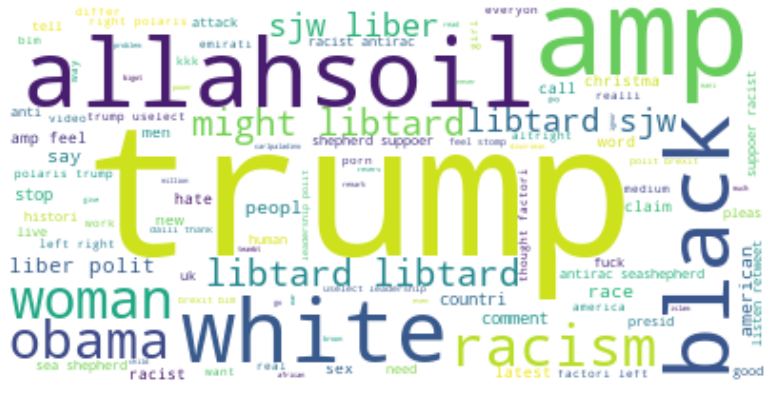

In [100]:
# Join the review.
long_string_neg = ','.join(list(test_df[test_df['Pred_class'] == 'Negative']['cleaned_tweet'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string_neg)
plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.title("Commonly used Negative words", pad = 14, weight = 'bold')
plt.show()

---
## 5) CONCLUSION

The above test concludes that it is possible to use machine learning to identify words that are commonly used on social media and predict if a user's post is negative or positive before it is posted online.

---
## 6) Next Steps...

One of the possible next steps would be to implement the model on any of the social media platforms to minimize the volume of bullying or negativity on the platform.